# MNIST Digits

In this notebook we are going to train a neural network to recognize handwritten digits. This is the  "Hello World" of deep learning: training a deep learning model to correctly classify hand-written digits.

In the previous [notebook](TheMNISTDataSet.ipynb) we downloaded the MNIST dataset, which is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.  We will re-use this data (downloaded either to your local hard drive or /transfer) to train a neural network to recognize the digits.

We will start by importing the necessary libraries, including our Utils module. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import struct
import sys
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

# Visualization tools
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F

sys.path.append("../")
import Utils

print(f"{Utils.in_lab()=}")

Utils.in_lab()=False


## GPU Support

In this notebook we will use the GPU to train our model, we can use the function from our Utils module to check if the GPU is available and set this as the device to use for our data. 

In [2]:
device = Utils.get_device()
print(device)

mps


## Image classification

The approach we are going to take with this example is to load a set of know images and their labels, and train a neural network to learn the relationship between the images and their labels. 

We will use a neural network and a trial and error system to begin to recognize the patterns in the images. The images are small (28x28 pixels) and the neural network will learn to recognize the patterns in the images that are associated with the digits.

We have a set of 60,000 images to train the network and a separate set of 10,000 images to test the network and on each step of the training process we will check the accuracy of the network on the test set.

In the previous notebook we created two functions for loading the data and labels so we will use these functions to load the data and labels for the training and test sets.

In [3]:
def load_mnist_labels(filename: str) -> np.ndarray:
    with open(filename, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        if len(labels) != num:
            raise ValueError(f"Expected {num} labels, but got {len(labels)}")
    return labels


def load_mnist_images(filename: str) -> np.ndarray:
    with open(filename, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
        if len(images) != num:
            raise ValueError(f"Expected {num} images, but got {len(images)}")
    return images

In [4]:
DATASET_LOCATION = ""
if Utils.in_lab():
    DATASET_LOCATION = "/transfer/MNIST/"
else:
    DATASET_LOCATION = "./MNIST/"

train_labels = load_mnist_labels(DATASET_LOCATION + "train-labels-idx1-ubyte")
test_labels = load_mnist_labels(DATASET_LOCATION + "t10k-labels-idx1-ubyte")

print(len(train_labels), len(test_labels))
print(train_labels[0], test_labels[0])

# We can now load the images from both the datasets.
train_images = load_mnist_images(DATASET_LOCATION + "train-images-idx3-ubyte")
test_images = load_mnist_images(DATASET_LOCATION + "t10k-images-idx3-ubyte")

60000 10000
5 7


To see the images we can define a simple function to display the images. We will use the matplotlib library to display the images.

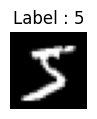

<class 'numpy.ndarray'>
(28, 28)
uint8


In [5]:
def display_image(image: np.array, label: str) -> None:
    plt.figure(figsize=(1, 1))
    plt.title(f"Label : {label}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()


# We can now display the first image from the training dataset.

display_image(train_images[0], train_labels[0])
print(type(train_images[0]))
print(train_images[0].shape)
print(train_images[0].dtype)

If we look at the data it is stored in a numpy array of 28,28 and a single unsigned char data type. We need to transform this data into the correct type for machine learning. In particular we need to convert the data into a Tensor of type float32, then we need to batch the data into a DataLoader.

We can use the torchvision library to transform our data as follows.

In [6]:
trans = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])
tensor = trans(train_images[0])
print(tensor.shape)
print(tensor.dtype)
print(tensor.min(), tensor.max())
print(tensor.device)

torch.Size([1, 28, 28])
torch.float32
tensor(0.) tensor(1.)
cpu


By default the data for this tensor is processed on the CPU, we can convert it to run on the GPU by using the .to(device) method.

In [7]:
tensor.to(device).device

device(type='mps', index=0)

## Preparing the Data for Training

Earlier, we created a `trans` variable to convert our ndarray to a tensor. [Transforms](https://pytorch.org/vision/stable/transforms.html) are a group of torchvision functions that can be used to transform a dataset.

At present our train_images and test_images are numpy arrays. We need to convert them to tensors. We can do this using the `trans` variable we created earlier.

In [8]:
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.uint8).to(device)

test_images_tensor = torch.tensor(test_images, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.uint8).to(device)

## Dataloaders

We can use the DataLoader class from the torch.utils.data module to create a DataLoader for our training and test data, you can think of this as batching images into smaller groups for training.

First we need to create a custom class to hold our data, we can do this by creating a subclass of the Dataset class from the torch.utils.data module. We need to implement the __len__ and __getitem__ methods to return the length of the dataset and the data and label for a given index.



In [9]:
# Custom dataset class
class DigitsDataset(Dataset):
    def __init__(self, images_tensor, labels_tensor):
        self.images_tensor = images_tensor
        self.labels_tensor = labels_tensor

    def __len__(self):
        return len(self.labels_tensor)

    def __getitem__(self, idx):
        image = self.images_tensor[idx]
        label = self.labels_tensor[idx]
        return image, label



We could show our models the entire dataset at once. Not only does this take a lot of computational resources, but [research shows](https://arxiv.org/pdf/1804.07612) using a smaller batch of data is more efficient for model training.

For example, if our `batch_size` is 32, we will train our model by shuffling the deck and drawing 32 cards. We do not need to shuffle for validation as the model is not learning, but we will still use a `batch_size` to prevent memory errors.

The batch size is something the model developer decides, and the best value will depend on the problem being solved. Research shows 32 or 64 is sufficient for many machine learning problems and is the default in some machine learning frameworks, so we will use 32 here.

In [10]:
batch_size = 32

train_data = DigitsDataset(train_images_tensor, train_labels_tensor)
valid_data = DigitsDataset(test_images_tensor, test_labels_tensor)


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)

## Creating a Model

Neural networks are composed of layers where each layer performs a mathematical operation on the data it receives before passing it to the next layer. To start, we will create a "Hello World" level model made from 4 components:

1. A [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) used to convert n-dimensional data into a vector. 
2. An input layer, the first layer of neurons
3. A hidden layer, another layer of neurons "hidden" between the input and output
4. An output layer, the last set of neurons which returns the final prediction from the model

We will use a variable called layers to store the layers of our model.


In [11]:
layers = []

## Flatten the image

The first thing we need to do is convert the image from a 28x28  array into a flat 1d tensor. We saw the images had 3 dimensions: `C x H x W`. To flatten an image means to combine all of these images into 1 dimension. Let's say we have a tensor like the one below. 

In [12]:
test_matrix = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(test_matrix)
print(nn.Flatten()(test_matrix))

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])


You will notice nothing happened, this is because neural networks expect to receive a batch of data. Currently, the Flatten layer sees three vectors as opposed to one 2d matrix. To fix this, we can "batch" our data by adding an extra pair of brackets. Since `test_matrix` is now a tensor, we can do that with the shorthand below. `None` adds a new dimension where `:` selects all the data in a tensor.

In [13]:
batch_test_matrix = test_matrix[None, :]
print(batch_test_matrix)
print(nn.Flatten()(batch_test_matrix))

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])


## The Input Layer

The input layer is the first layer of neurons in the neural network. It is responsible for receiving the input data and passing it to the next layer. 

This layer will be *densely connected*, meaning that each neuron in it, and its weights, will affect every neuron in the next layer.

In order to create these weights, Pytorch needs to know the size of our inputs and how many neurons we want to create. 
Since we've flattened our images, the size of our inputs is the number of channels, number of pixels vertically, and number of pixels horizontally multiplied together.

In [14]:
input_size = 1 * 28 * 28
print(input_size)

784


Choosing the correct number of neurons is what puts the "science" in "data science" as it is a matter of capturing the statistical complexity of the dataset. For now, we will use `512` neurons. Try playing around with this value later to see how it affects training and to start developing a sense for what this number means.

We will learn more about activation functions later, but for now, we will use the [relu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) activation function, which in short, will help our network to learn how to make more sophisticated guesses about data than if it were required to make guesses based on some strictly linear function.

In [15]:
layers = [nn.Flatten(), nn.Linear(input_size, 512), nn.ReLU()]  # Input  # Activation for input
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU()]

## The hidden layer

A hidden layer is a layer of neurons between the input and output layers. It is called "hidden" because it is not directly exposed to the input data and the output predictions. We will cover why we combine multiple layers in another lecture, but for now, we will add a hidden layer to our model.

As with the previous layers, the shape of the data is important. [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) needs to know the shape of the data being passed to it. Each neuron in the previous layer will compute one number, so the number of inputs into the hidden layer is the same as the number of neurons in the previous later.

In [16]:
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU()]

## The Output Layer

The output layer is the final layer of neurons in the neural network. It is responsible for producing the output of the model. This will be a tensor of length 10, where each element represents the probability of the input image being a particular digit.

We will not assign the `relu` function to the output layer. Instead, we will apply a `loss function` covered in the next section.

In [17]:
n_classes = 10

layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
    nn.Linear(512, n_classes),  # Output
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=10, bias=True)]

## Compiling the Model

A [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) model expects a sequence of arguments, not a list, so we can use the [* operator](https://docs.python.org/3/reference/expressions.html#expression-lists) to unpack our list of layers into a sequence. We can print the model to verify these layers loaded correctly. We can also send our model to the GPU using the to(device) method. We can verify where the model is by using the .device attribute.

In [18]:
model = nn.Sequential(*layers)
model.to(device)
next(model.parameters()).device

device(type='mps', index=0)

PyTorch 2.0 introduced the ability to [compile]([here](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html).) the model using the `compile` method which can give faster performance.  However it does not work with mps backend. 

In [19]:
if device == "cuda":
    model = torch.compile(model)

## Training the Model

Now that we have prepared training and validation data, and a model, it's time to train our model with our training data, and verify it with its validation data.

This is called fitting and we need to add two functions to help us with this process.

## Loss and Optimization

The loss function measures the difference between the model's prediction and the target. The optimizer updates the model's parameters to reduce the loss. In this example we will use  a loss function called [CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) which is designed to grade if a model predicted the correct category from a group of categories.

In [20]:
loss_function = nn.CrossEntropyLoss()

The optimizer is used to update the model's weights based on the data it sees and the loss function. We will use the [Adam](https://pytorch.org/docs/stable/optim.html) optimizer, which is a popular optimizer in deep learning. It needs to know the models parameters so it can update them. 

In [21]:
optimizer = Adam(model.parameters())

## Accuracy

When training a model, it is important to know how well it is performing. We can calculate the accuracy of the model by comparing the model's prediction to the actual target. The simplest way to do this is to compare the model's prediction to the target and calculate the percentage of correct predictions. 

We need to generate our own accuracy functions as these are typically dependent on the problem being solved.

We need to compare the number of correct classifications compared to the total number of predictions made. Since we're showing data to the model in batches, our accuracy can be calculated along with these batches.

We typically use N as a postfix to denote the number of samples in a dataset. We can use this to calculate the accuracy of our model.

In [22]:
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)

We can then accumulate the accuracy for each batch and divide by the total number of samples to get the overall accuracy.

In [23]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

## The Training Loop

We now generate a function that will train the model for a single epoch. This is similar to the approch we used in the the Linear example but we have added a few more steps to calculate the accuracy of the model.

In [24]:
def train():
    loss = 0
    accuracy = 0
    # put model into training mode
    model.train()
    # send data to the device
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print("Train - Loss: {:.4f} Accuracy: {:.4f}".format(loss, accuracy))

## Validation

Once the model has done a training step we need to see how close we are to the correct answer. We can do this by running the model on the validation data and calculating the loss and accuracy of the model on the validation data. Agin we will use a function to do this. 

In [25]:
def validate():
    loss = 0
    accuracy = 0
    # put model into evaluation mode
    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print("Valid - Loss: {:.4f} Accuracy: {:.4f}".format(loss, accuracy))

## The Training loop

We can now create a training loop that will train the model for a number of epochs. An `epoch` is one complete pass through the entire dataset. Let's train and validate the model for 5 `epochs` to see how it learns.

In [26]:
epochs = 10

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 639.9409 Accuracy: 0.9217
Valid - Loss: 57.4882 Accuracy: 0.9498
Epoch: 1
Train - Loss: 341.3024 Accuracy: 0.9512
Valid - Loss: 62.9680 Accuracy: 0.9471
Epoch: 2
Train - Loss: 278.1897 Accuracy: 0.9598
Valid - Loss: 49.6020 Accuracy: 0.9568
Epoch: 3
Train - Loss: 245.2574 Accuracy: 0.9654
Valid - Loss: 50.5998 Accuracy: 0.9629
Epoch: 4
Train - Loss: 220.6764 Accuracy: 0.9696
Valid - Loss: 46.5469 Accuracy: 0.9665
Epoch: 5
Train - Loss: 185.5318 Accuracy: 0.9729
Valid - Loss: 60.5998 Accuracy: 0.9582
Epoch: 6
Train - Loss: 192.8441 Accuracy: 0.9744
Valid - Loss: 65.3466 Accuracy: 0.9604
Epoch: 7
Train - Loss: 182.3354 Accuracy: 0.9773
Valid - Loss: 37.6866 Accuracy: 0.9734
Epoch: 8
Train - Loss: 163.7126 Accuracy: 0.9797
Valid - Loss: 45.9748 Accuracy: 0.9703
Epoch: 9
Train - Loss: 157.2278 Accuracy: 0.9793
Valid - Loss: 56.8652 Accuracy: 0.9630


We can see that we are quite close (nearly 100%) so we can try and test our model on some existing data. 

In [ ]:
prediction = model(test_images_tensor[0].to(device).unsqueeze(0))
prediction

There should be ten numbers, each corresponding to a different output neuron. Thanks to how the data is structured, the index of each number matches the corresponding handwritten number. The 0th index is a prediction for a handwritten 0, the 1st index is a prediction for a handwritten 1, and so on.

We can use the `argmax` function to find the index of the highest value.

tensor([[7]], device='mps:0')


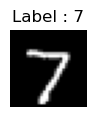

In [30]:
print(prediction.argmax(dim=1, keepdim=True))
display_image(test_images[0], prediction.argmax(dim=1, keepdim=True).item())

This seems to have worked, we should now save the model so we can use it later.

## Saving the Model

We can save the model using the torch.save function. We can save the model to a file called `digits.pth` in the current directory.

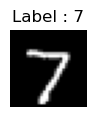

In [31]:
# save the model
torch.save(model.state_dict(), "mnist_model.pth")
# now re-load the model into a new model to verify

model2 = nn.Sequential(*layers)
model2.load_state_dict(torch.load("mnist_model.pth"))
model2.to(device)
model2.eval()
prediction = model2(test_images_tensor[0].to(device).unsqueeze(0))
torch.save(test_images_tensor[0], "test_image.pth")
display_image(test_images[0], prediction.argmax(dim=1, keepdim=True).item())

In the above case we saved only the model state dictionary. We can also save the entire model including the architecture and the state dictionary. This is a little more rigid as it requires the model to be defined in the same way when it is loaded, however we don't also need to re-create the model architecture when we load the model.

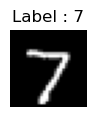

In [32]:
torch.save(model, "minst_model_full.pth")
model3 = torch.load("minst_model_full.pth")
model3.to(device)
model3.eval()
prediction = model3(test_images_tensor[0].to(device).unsqueeze(0))
display_image(test_images[0], prediction.argmax(dim=1, keepdim=True).item())

We can now use this model to classify new images of digits. We will demonstrate this in a stand alone Qt applications.

## Clearing the GPU

Sometimes it is best to clear the GPU memory after training a model. There are a number of ways to do this but we can use IPython to re-start the kernel which will clear the GPU memory. There is a function in the Utils module that will do this for you.

In [31]:
Utils.shutdown_kernel()

: 


## Conclusion

In this notebook we have trained a neural network to recognize handwritten digits. We have used the MNIST dataset to train the model and have used a simple neural network with a single hidden layer to classify the images. We have trained the model for 5 epochs and have achieved an accuracy of nearly 100%. We have saved the model so we can use it later.

This is basically the process we will use for all of our machine learning models. We will load the data, create a model, train the model and then save the model. We can then use the model to classify new data.